## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

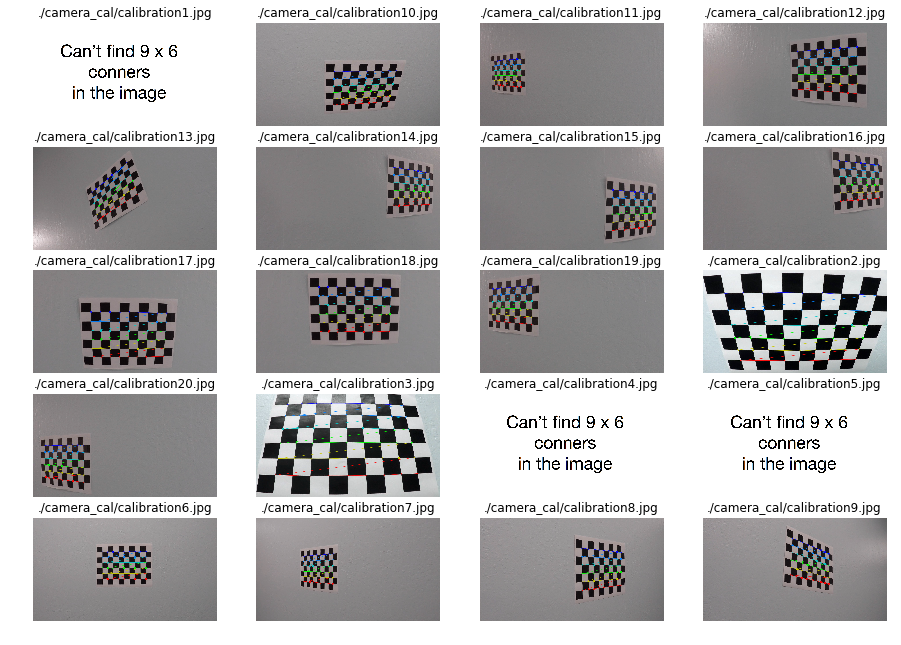

In [225]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Define the plot
number_of_images = len(images)
images_per_raw = 5
image_on_failure = './camera_cal/conner_not_found.png'

fig, axs = plt.subplots(images_per_raw, int(number_of_images / images_per_raw), figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# process all the images
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        cv2.waitKey(500)
        
        axs[i].axis('off')
        axs[i].imshow(img)
        axs[i].set_title(fname)
    else:
        img = cv2.imread(image_on_failure)
        axs[i].axis('off')
        axs[i].imshow(img)
        axs[i].set_title(fname)

In [226]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## Apply a distortion correction to raw images.

Text(0.5,1,'Undistorted Image')

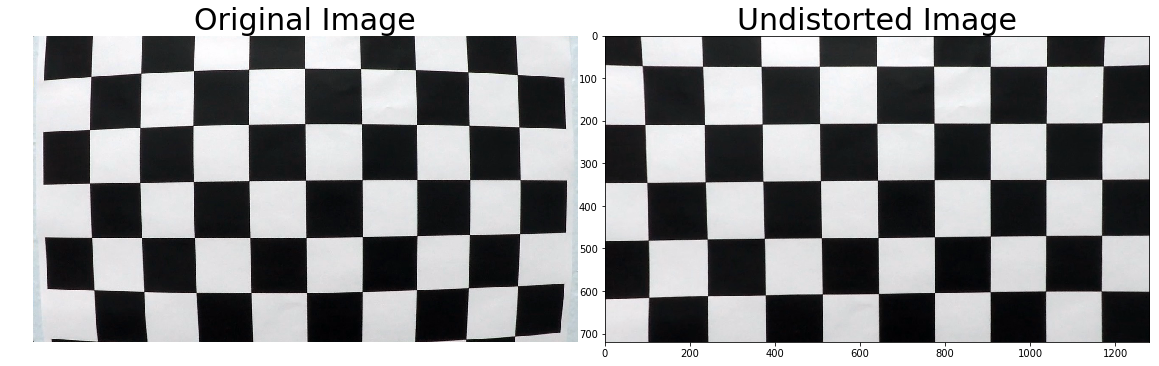

In [227]:
undist = cv2.undistort(img, mtx, dist, None, mtx)

figure, axes = plt.subplots(1, 2, figsize=(20,10))
figure.subplots_adjust(hspace = .2, wspace=.05)

axes[0].axis('off')
axes[0].imshow(img)
axes[0].set_title('Original Image', fontsize=30)
axes[0].axis('off')
axes[1].imshow(undist)
axes[1].set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [228]:
def undistort(raw_image):
    return cv2.undistort(raw_image, mtx, dist, None, mtx)

def s_chanel_threshold(raw_image, thresh_min = 175, thresh_max = 255):
    hls = cv2.cvtColor(raw_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary
    
def abs_sobel_threshold(raw_image, thresh_min = 25, thresh_max = 100):
    gray = cv2.cvtColor(raw_image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_threshold(image, thresh_min = 30, thresh_max = 100):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    return binary_output

def dir_threshold(image, thresh_min=0.7, thresh_max = 1.3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1

    return absgraddir

def stack_binary(raw_image):
    undist = undistort(raw_image)
    
    gradx = abs_sobel_threshold(undist)
    mag_binary = mag_threshold(undist)
    dir_binary = dir_threshold(undist)
    s_binary = s_chanel_threshold(undist)
    
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | (gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

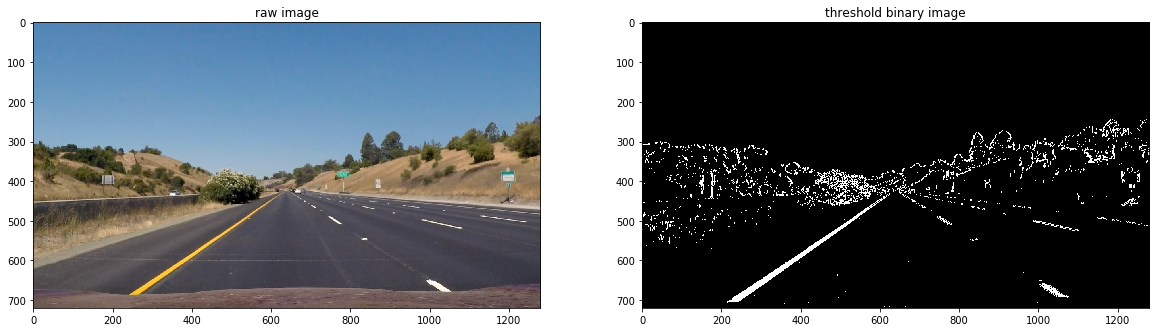

In [229]:
test_image = cv2.imread('./test_images/straight_lines1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_binary = stack_binary(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('raw image')
ax1.imshow(test_image)

ax2.set_title('threshold binary image')
ax2.imshow(test_image_binary, cmap='gray')


## Apply a perspective transform to rectify binary image ("birds-eye view").

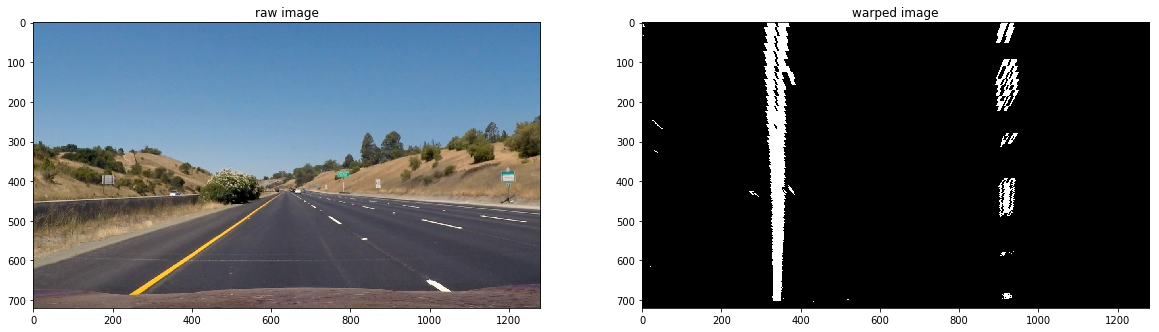

In [300]:
def warper(binary_image, src, dst):
    img_size = (binary_image.shape[1], binary_image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(binary_image, M, img_size, flags=cv2.INTER_NEAREST)

    return warped

src = np.float32([[585,455],[700,455],[200, 700],[1128,700]])
dst = np.float32([[315,0],[958,0],[315,700],[958,700]])

test_image_warp = warper(test_image_binary, src, dst)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('raw image')
ax1.imshow(test_image)

ax2.set_title('warped image')
ax2.imshow(test_image_warp, cmap='gray')



## Detect lane pixels and fit to find the lane boundary.

In [301]:
def detect_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9

    window_height = np.int(binary_warped.shape[0]//nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img,(win_xleft_low, win_y_low),(win_xleft_high, win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, left_fit, right_fit

def detect_lane_with_estimate(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                                    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    window_img = np.zeros_like(out_img)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])

    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fit, right_fit

(720, 0)

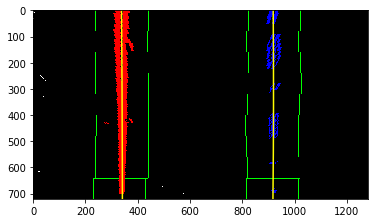

In [302]:
out_img, left_fit, right_fit = detect_lane_pixels(test_image_warp)

ploty1 = np.linspace(0, test_image_warp.shape[0]-1, test_image_warp.shape[0] )
left_fitx1 = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx1 = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx1, ploty1, color='yellow')
plt.plot(right_fitx1, ploty1, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



(720, 0)

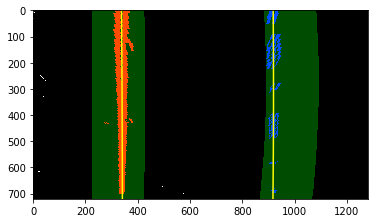

In [303]:
result, left_fit2, right_fit2 = detect_lane_with_estimate(test_image_warp,left_fit,right_fit)
ploty2 = np.linspace(0, test_image_warp.shape[0]-1, test_image_warp.shape[0] )
left_fitx2 = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx2 = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(result)
plt.plot(left_fitx2, ploty2, color='yellow')
plt.plot(right_fitx2, ploty2, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Determine the curvature of the lane and vehicle position with respect to center.

In [304]:
def curve_radius(binary_warp, left_fit, right_fit):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 

    ploty = np.linspace(0, binary_warp.shape[0]-1, binary_warp.shape[0] )
    y_eval = np.max(ploty)

    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    image_center = binary_warp.shape[1] / 2
    image_height = binary_warp.shape[0]
    l_fit_x_int = left_fit[0]*image_height**2 + left_fit[1]*image_height + left_fit[2]
    r_fit_x_int = right_fit[0]*image_height**2 + right_fit[1]*image_height + right_fit[2]
    lane_center = (r_fit_x_int + l_fit_x_int) / 2
    center_dist = (image_center - lane_center) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

left radius:  2061.3274735715954 m, right rasius:  1818.6562124107998 m, center:  -0.18567835327241958 m.


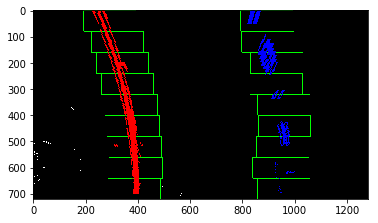

In [342]:
curve_image = cv2.imread('./test_images/test2.jpg')
curve_image = cv2.cvtColor(curve_image, cv2.COLOR_BGR2RGB)
curve_image_binary = stack_binary(curve_image)
curve_image_warp = warper(curve_image_binary, src, dst)
curve_img, left_fit, right_fit = detect_lane_pixels(curve_image_warp)

plt.imshow(curve_img)


left_curverad, right_curverad, center_dist = curve_radius(curve_image_warp, left_fit, right_fit)
print('left radius: ', left_curverad, 'm, right rasius: ',  right_curverad, 'm, center: ', center_dist, 'm.')

## Warp the detected lane boundaries back onto the original image.

In [343]:
def draw_lane(raw_image, binary_image, l_fit, r_fit, src, dst):
    warp_zero = np.zeros_like(binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height,weight = binary_image.shape
    ploty = np.linspace(0, height - 1, num = height)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (weight, height)) 

    result = cv2.addWeighted(np.copy(raw_image), 1, newwarp, 0.5, 0)
    return result

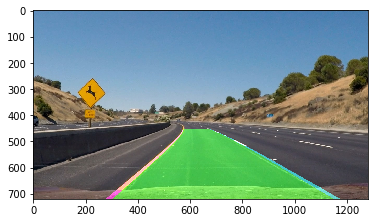

In [344]:
newwarp = draw_lane(curve_image, curve_image_warp, left_fit, right_fit, src, dst)
plt.imshow(newwarp)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [373]:
def write_numerical(original_img, left_radius, right_radius, center_dist):
    new_img = np.copy(original_img)
    height = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    curve_text = 'Curve radius: ' + '{:04.2f}'.format((left_radius + right_radius) / 2) + "m."
    center_text = '{:.2f}'.format(abs(center_dist)) +  (' left' if center_dist < 0 else ' right') + ' from center.'
    cv2.putText(new_img, curve_text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(new_img, center_text, (40,140), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

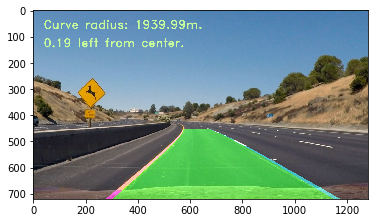

In [374]:
result = write_numerical(newwarp, left_curverad, right_curverad, center_dist)
plt.imshow(result)

## Create the pipline to process image

In [381]:
def process_pipline(raw_image):
    global src, dst
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    image_binary = stack_binary(raw_image)
    image_warp = warper(image_binary, src, dst)
    curve_img, left_fit, right_fit = detect_lane_pixels(image_warp)
    left_curverad, right_curverad, center_dist = curve_radius(curve_img, left_fit, right_fit)
    marked_image = draw_lane(raw_image, image_binary, left_fit, right_fit, src, dst)
    texted_image = write_numerical(marked_image, left_curverad, right_curverad, center_dist)
    return texted_image

In [383]:
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("project_video.mp4")
output1 = 'test_video1.mp4'

out_clip = clip1.fl_image(process_pipline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████▉| 1260/1261 [03:46<00:00,  5.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

CPU times: user 4min 1s, sys: 1min 3s, total: 5min 4s
Wall time: 3min 46s


In [385]:
clip2 = VideoFileClip("challenge_video.mp4")
output2 = 'test_video2.mp4'

out_clip2 = clip2.fl_image(process_pipline) #NOTE: this function expects color images!!
%time out_clip2.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video test_video2.mp4
[MoviePy] Writing video test_video2.mp4


100%|██████████| 485/485 [01:23<00:00,  6.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video2.mp4 

CPU times: user 1min 32s, sys: 20.9 s, total: 1min 53s
Wall time: 1min 23s
